# 🔍 Attention Heatmaps Lab (DistilBERT)

Welcome! In this short, hands‑on lab you will:
1) run a tiny Transformer (DistilBERT), 2) extract its attention weights, 3) see them as a matrix and heatmap, and 4) **play** with the input sentence to notice how attention shifts.

As you go, try the mini‑challenges marked with **Try it**. Keep the notebook responsive by changing a single parameter at a time and observing what moves. 🧪


## Step 1 — Set up the environment
We’ll install the essentials: **PyTorch**, **Transformers**, **pandas**, and **matplotlib**.

In [2]:
!pip install torch transformers pandas matplotlib --quiet


## Step 2 — Pick a model, a sentence, and how to aggregate heads
We’ll load **DistilBERT** with attention outputs enabled. You can tweak:
- `sentence`: the text you want to probe.
- `layer`: which Transformer layer’s attention to inspect (use negative numbers to count from the end; `-1` means last layer).
- `aggregate`: combine heads by `'mean'`, `'max'`, or use `None` to look at a single `head`.

**Try it**: change the *tense* or *structure* of the sentence. Add punctuation, swap word order, or insert a negation. Watch how the matrix changes. ✍️

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModel

# SETTINGS — change these and re-run this cell + the next ones
model_name = "distilbert-base-uncased"
sentence = "The dog is barking loudly"
layer = -1         # -1 = last layer
head = 0           # used only if aggregate is None
aggregate = "mean" # 'mean', 'max', or None

# Load model & tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True).to(device)
model.eval()

# Encode & run forward
inputs = tokenizer(sentence, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)
attentions = outputs.attentions  # tuple: (layers) each -> (batch, heads, q_len, k_len)

# Select layer
L = len(attentions)
if layer < 0:
    layer = L + layer
attn_layer = attentions[layer][0]  # (heads, seq_len, seq_len)

# Aggregate heads if requested
if aggregate:
    if aggregate == "mean":
        attn = attn_layer.mean(dim=0).cpu().numpy()
    elif aggregate == "max":
        attn = attn_layer.max(dim=0).values.cpu().numpy()
    else:
        raise ValueError("aggregate must be 'mean' or 'max' or None")
else:
    attn = attn_layer[head].cpu().numpy()

# Convert IDs to tokens
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Remove special tokens and punctuation to keep it tidy
drop = {"[CLS]", "[SEP]", "."}
keep_idx = [i for i, tok in enumerate(tokens) if tok not in drop]
tokens_clean = [tokens[i] for i in keep_idx]
attn_clean = attn[np.ix_(keep_idx, keep_idx)]

# Build a DataFrame view
df = pd.DataFrame(attn_clean, index=tokens_clean, columns=tokens_clean)
display(df.head(len(tokens_clean)))


,the,dog,is,barking,loudly
the,0.077133,0.039372,0.063618,0.019805,0.020847
dog,0.038804,0.061803,0.027142,0.025852,0.021205
is,0.059803,0.021764,0.106767,0.020769,0.028329
barking,0.027493,0.029564,0.031773,0.043064,0.035417
loudly,0.029521,0.018803,0.052118,0.036681,0.092074


## Step 3 — Visualise the attention matrix as a heatmap
This chart shows how much each **query token** pays attention to each **key token**. Darker squares mean stronger attention.

**Try it**: switch `aggregate` to `None` and cycle different `head` indices. Some heads focus on local syntax, others on long‑range links. 🎯

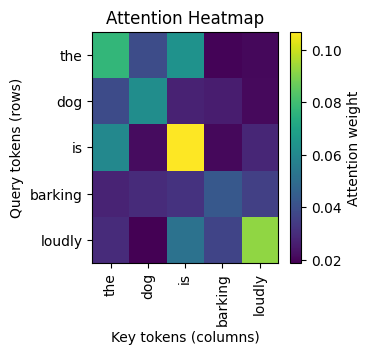

In [22]:
plt.figure(figsize=(0.6*len(tokens_clean), 0.6*len(tokens_clean)))
plt.imshow(attn_clean, interpolation="nearest", aspect="auto")
plt.title("Attention Heatmap")
plt.xlabel("Key tokens (columns)")
plt.ylabel("Query tokens (rows)")
plt.xticks(np.arange(len(tokens_clean)), tokens_clean, rotation=90)
plt.yticks(np.arange(len(tokens_clean)), tokens_clean)
plt.colorbar(label="Attention weight")
plt.show()


## Reflection & mini‑challenges
• **Head hunting**: with `aggregate=None`, sweep `head` from 0 upward. Do you find a head that concentrates on determiners like `the` or on verbs?

• **Perturbation**: insert or remove commas. Do attention links become more or less focused?

• **Semantic shift**: replace `dog` with `cat`, or with a multi‑token word (e.g. `sheep-dog`). Observe whether the model splits it into subwords and how attention behaves.

• **Layer depth**: try `layer=-6` (first DistilBERT layer) vs `layer=-1`. Do early layers attend more locally?

Jot down quick notes about what surprised you. 📝